In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [3]:
# Check if MPS is available to use GPU from mac
print(torch.__version__)
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

2.6.0
True
True
Using device: mps


In [4]:
data = pd.read_csv('cleaned_data_train.csv')
data_test = pd.read_csv('cleaned_data_test.csv')



In [5]:
class CreditScoreMDNModel(nn.Module):
    def __init__(self, 
                 num_categories1, embedding_dim1, 
                 num_categories2, embedding_dim2, 
                 continuous_dim,  
                 hidden_dim, 
                 num_components=2):
        super(CreditScoreMDNModel, self).__init__()
        
        # Embedding layers for each categorical variable
        self.embedding1 = nn.Embedding(num_categories1, embedding_dim1)
        self.embedding2 = nn.Embedding(num_categories2, embedding_dim2)
        
        # Compute the combined input dimension
        total_embedding_dim = embedding_dim1 + embedding_dim2
        input_dim = total_embedding_dim + continuous_dim
        
        # Base network to extract features
        self.base = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Dropout(0.3)
        )
        
        # MDN output layers
        self.pi_layer = nn.Linear(hidden_dim // 2, num_components)  # mixing coefficients
        self.mu_layer = nn.Linear(hidden_dim // 2, num_components)   # expected value of the normal
        self.sigma_layer = nn.Linear(hidden_dim // 2, num_components)  # standard deviation of the normal
        
    def forward(self, categorical_input1, categorical_input2, continuous_input):
        # Process categorical inputs
        embedded1 = self.embedding1(categorical_input1)  # (batch_size, embedding_dim1)
        embedded2 = self.embedding2(categorical_input2)  # (batch_size, embedding_dim2)
        x_cat = torch.cat([embedded1, embedded2], dim=1)
        
        # Concatenate with continuous features
        x = torch.cat([x_cat, continuous_input], dim=1)
        
        # Extract shared features
        h = self.base(x)
        
        # Mixing coefficients
        pi = self.pi_layer(h)              
        pi = F.softmax(pi, dim=1)  # Ensure they sum to 1
        
        # Means for each component
        mu = self.mu_layer(h)
        
        # Standard deviations (using softplus to enforce positivity and numerical stability)
        sigma = self.sigma_layer(h)
        sigma = F.softplus(sigma) + 1e-6  # small constant to avoid exact zero
        
        return pi, mu, sigma

In [6]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in dataloader:
            # Unpack batch data: categorical_input1, categorical_input2, continuous_input, and targets
            categorical_input1, categorical_input2, continuous_input, targets = batch
            
            categorical_input1 = categorical_input1.to(device)
            categorical_input2 = categorical_input2.to(device)
            if continuous_input is not None:
                continuous_input = continuous_input.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            # For an MDN, the model returns three outputs: pi, mu, sigma
            pi, mu, sigma = model(categorical_input1, categorical_input2, continuous_input)
            # The criterion should be your MDN loss function which takes (pi, mu, sigma) and targets
            loss = criterion(pi, mu, sigma, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * targets.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    return model

In [10]:
num_categories1 = data.industry.unique().shape[0]
embedding_dim1 = 12          # Embedding dimension for the first variable
num_categories2 = data.year.unique().shape[0]
embedding_dim2 = 3           # Embedding dimension for the second variable
continuous_dim = data.shape[1] - 3    
hidden_dim = 16             
num_components = 2           # For bimodal distribution

num_epochs = 100
batch_size = 256
learning_rate = 0.001

# Initialize MDN model, criterion, and optimizer
model = CreditScoreMDNModel(num_categories1, embedding_dim1, 
                            num_categories2, embedding_dim2,
                            continuous_dim, hidden_dim, 
                            num_components)

# MDN loss function: computes negative log-likelihood of target under mixture model
def mdn_loss(pi, mu, sigma, target):
    # Create a normal distribution for each component
    m = torch.distributions.Normal(mu, sigma)
    # Compute probability of target under each Gaussian component (adjust dimensions as needed)
    prob = m.log_prob(target.unsqueeze(-1)).exp()  
    # Weight the probabilities by the mixing coefficients
    weighted_prob = pi * prob
    # Sum over the components and compute the negative log-likelihood
    likelihood = weighted_prob.sum(dim=-1)
    nll = -torch.log(likelihood + 1e-8).mean()
    return nll

criterion = mdn_loss  # Use the MDN loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.003)

In [11]:
categorical_data1 = torch.tensor(data.industry.values, dtype=torch.long)
categorical_data2 = torch.tensor(data.year.values, dtype=torch.long)
continuous_data = torch.tensor(
    data.drop(columns=['industry', 'year', 'credit_score']).values, 
    dtype=torch.float32
)
targets = torch.tensor(data.credit_score.values, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(categorical_data1, categorical_data2, continuous_data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print the model architecture
print("Model Architecture:")
print(model)

Model Architecture:
CreditScoreMDNModel(
  (embedding1): Embedding(85, 12)
  (embedding2): Embedding(13, 3)
  (base): Sequential(
    (0): Linear(in_features=40, out_features=16, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): SiLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (pi_layer): Linear(in_features=8, out_features=2, bias=True)
  (mu_layer): Linear(in_features=8, out_features=2, bias=True)
  (sigma_layer): Linear(in_features=8, out_features=2, bias=True)
)


In [12]:
trained_model = train_model(model, dataloader, criterion, optimizer, device, num_epochs)

Epoch 1/100, Loss: 6.7139
Epoch 2/100, Loss: 4.2410
Epoch 3/100, Loss: 2.9420
Epoch 4/100, Loss: 2.5861
Epoch 5/100, Loss: 2.3923
Epoch 6/100, Loss: 2.2816
Epoch 7/100, Loss: 2.2100
Epoch 8/100, Loss: 2.1581
Epoch 9/100, Loss: 2.1454
Epoch 10/100, Loss: 2.0773
Epoch 11/100, Loss: 2.0068
Epoch 12/100, Loss: 2.0078
Epoch 13/100, Loss: 1.9650
Epoch 14/100, Loss: 1.9322
Epoch 15/100, Loss: 1.8997
Epoch 16/100, Loss: 1.8673
Epoch 17/100, Loss: 1.8316
Epoch 18/100, Loss: 1.7764
Epoch 19/100, Loss: 1.7569
Epoch 20/100, Loss: 1.7219
Epoch 21/100, Loss: 1.6909
Epoch 22/100, Loss: 1.6697
Epoch 23/100, Loss: 1.6428
Epoch 24/100, Loss: 1.6207
Epoch 25/100, Loss: 1.5926
Epoch 26/100, Loss: 1.5489
Epoch 27/100, Loss: 1.5100
Epoch 28/100, Loss: 1.5159
Epoch 29/100, Loss: 1.4784
Epoch 30/100, Loss: 1.4681
Epoch 31/100, Loss: 1.4552
Epoch 32/100, Loss: 1.4399
Epoch 33/100, Loss: 1.4291
Epoch 34/100, Loss: 1.4236
Epoch 35/100, Loss: 1.4256
Epoch 36/100, Loss: 1.4205
Epoch 37/100, Loss: 1.4162
Epoch 38/1

In [13]:
# Predict using the trained model
categorical_data1_ = torch.tensor(data_test.industry.values, dtype=torch.long)
categorical_data2_ = torch.tensor(data_test.year.values, dtype=torch.long)
continuous_data_ = torch.tensor(
    data_test.drop(columns=['industry', 'year', 'credit_score']).values, dtype=torch.float32
)
y_test = torch.tensor(data_test.credit_score.values, dtype=torch.float32)

test_dataset = TensorDataset(categorical_data1_, categorical_data2_, continuous_data_)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model.eval()
model.to('cpu')
predictions = []
with torch.no_grad():
    for batch in test_loader:
        cat1, cat2, cont = batch
        # MDN outputs: mixing coefficients (pi), means (mu), and standard deviations (sigma)
        pi, mu, sigma = model(cat1, cat2, cont)
        # Compute the expected value: weighted sum of the means
        pred = (pi * mu).sum(dim=1)
        predictions.append(pred)

predictions = torch.cat(predictions, dim=0)
predictions = predictions.numpy()

# Compute the Mean Squared Error (MSE)
mse = np.mean(abs(predictions - y_test.numpy()))
print("MSE:", mse)

MSE: 0.7139668


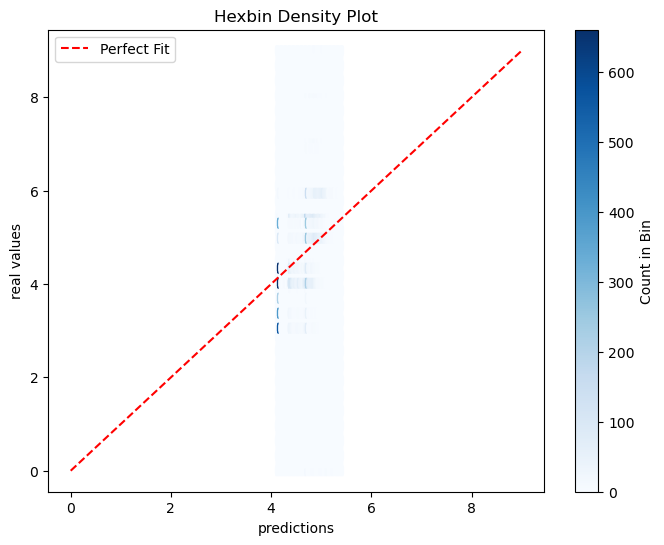

In [14]:
plt.figure(figsize=(8, 6))
hb = plt.hexbin(predictions, y_test, gridsize=50, cmap='Blues')

line_min = min(y_test.min(), y_test.min())
line_max = max(y_test.max(), y_test.max())
plt.plot([line_min, line_max], [line_min, line_max], 'r--', label='Perfect Fit')

plt.xlabel('predictions')
plt.ylabel('real values')
plt.title('Hexbin Density Plot')
plt.colorbar(hb, label='Count in Bin')
plt.legend()
plt.show()

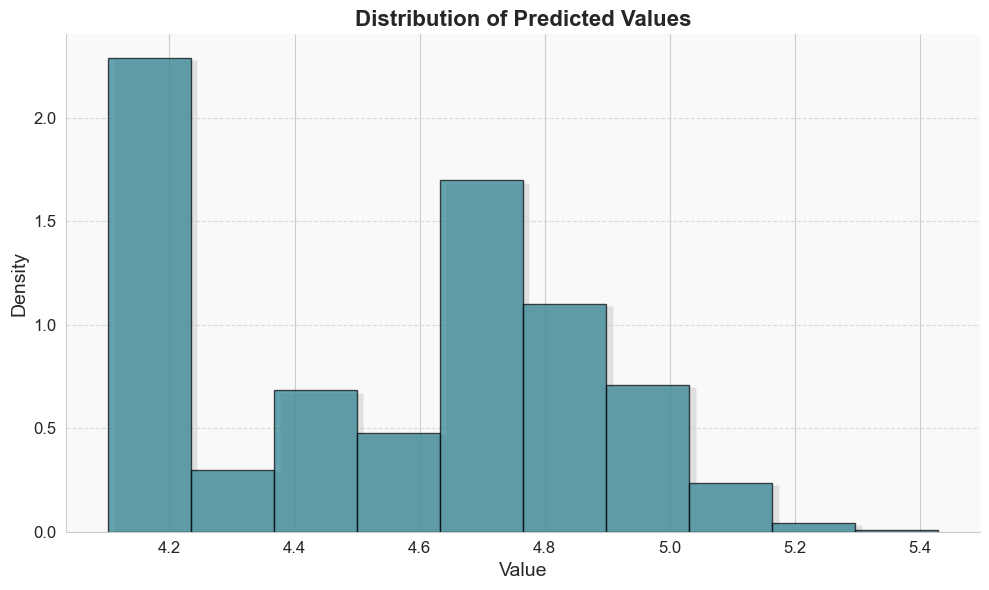

In [20]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))  
n, bins, patches = plt.hist(predictions, bins=10, density=True, alpha=0.7, color=sns.color_palette("viridis")[2], edgecolor='black', linewidth=1)

plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Predicted Values', fontsize=16, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.gca().set_facecolor('#f9f9f9')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for patch in patches:
    patch.set_zorder(1) 
    x, y = patch.xy
    w, h = patch.get_width(), patch.get_height()
    plt.gca().add_patch(plt.Rectangle((x+0.01, y-0.01), w, h, facecolor='black', alpha=0.1, zorder=0))

plt.tight_layout() 
plt.show()